In [2]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use("bmh")

import numpy as np
from scipy.stats import binom
from DP.utils import (
    binom_derivative,
    binom_optimal_privacy,
    fisher_gradient,
    fisher_information_privatized
)
from DP.linear_solver import LinearSolver
from DP.pga_with_edge_traversal import PGAWithEdgeTraversal
from DP.scipy_solver import ScipySolver
from matplotlib.patches import FancyArrowPatch

## Feasible set

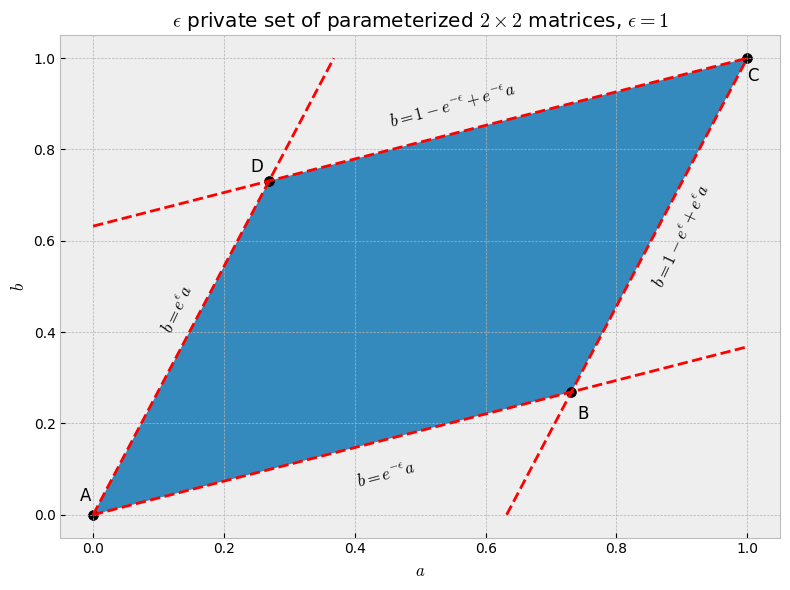

In [84]:
EPSILON = 1

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot([0, np.exp(-EPSILON)], [0, 1], color="red", linestyle="dashed")
ax.plot([0, 1], [0, np.exp(-EPSILON)], color="red", linestyle="dashed")

ax.plot([0, 1], [1 - np.exp(-EPSILON), 1], color="red", linestyle="dashed")
ax.plot([1 - np.exp(-EPSILON), 1], [0, 1], color="red", linestyle="dashed")

ax.fill_between(
    x=[0, (1 - np.exp(-EPSILON)) / (np.exp(EPSILON) - np.exp(-EPSILON)), (1 - np.exp(EPSILON)) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1], 
    y1=[0, (np.exp(EPSILON) - 1) / (np.exp(EPSILON) - np.exp(-EPSILON)), 1 - np.exp(-EPSILON) + (np.exp(-EPSILON) - 1) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1],
    y2=[0, (1 - np.exp(-EPSILON)) / (np.exp(2*EPSILON) - 1), (np.exp(-EPSILON) - 1) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1]
)

ax.scatter([0, (1-np.exp(EPSILON)) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1, (1-np.exp(-EPSILON)) / (np.exp(EPSILON) - np.exp(-EPSILON))],
           [0, (np.exp(-EPSILON) - 1) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1, (np.exp(EPSILON) - 1) / (np.exp(EPSILON) - np.exp(-EPSILON))],
           s=50, color="black")

ax.annotate(r"$b = e^\epsilon a$", xy=(0.10, 0.4), fontsize="large", rotation=65)
ax.annotate(r"$b = e^{-\epsilon} a$", xy=(0.4, 0.06), fontsize="large", rotation=15)
ax.annotate(r"$b = 1 - e^{-\epsilon} + e^{-\epsilon}a$", xy=(0.45, 0.85), fontsize="large", rotation=15)
ax.annotate(r"$b = 1 - e^\epsilon + e^\epsilon a$", xy=(0.85, 0.5), fontsize="large", rotation=65)

ax.annotate("A", xy=(-0.02, 0.03), fontsize="large")
ax.annotate("B", xy=(0.74, 0.21), fontsize="large")
ax.annotate("C", xy=(1, 0.95), fontsize="large")
ax.annotate("D", xy=(0.24, 0.75), fontsize="large")

ax.set_xlabel("$a$")
ax.set_ylabel("$b$")
ax.set_title(r"$\epsilon$ private set of parameterized $2\times 2$ matrices, $\epsilon=1$")

plt.tight_layout()
plt.savefig("figures/epsilon_private_set.png")
plt.show()

## Objective function with gradient

/Users/matej.vedak/Desktop/University of Vienna/Lukas master thesis/locally_efficient_differential_privacy/DP/utils.py:104: RuntimeWarning: invalid value encountered in divide
  2 * np.outer(p_theta_dot, Q_ptheta_dot) / Q_ptheta
/Users/matej.vedak/Desktop/University of Vienna/Lukas master thesis/locally_efficient_differential_privacy/DP/utils.py:105: RuntimeWarning: invalid value encountered in divide
  - np.outer(p_theta, Q_ptheta_dot_squared) / Q_ptheta_squared
/Users/matej.vedak/Desktop/University of Vienna/Lukas master thesis/locally_efficient_differential_privacy/DP/utils.py:177: RuntimeWarning: invalid value encountered in divide
  return np.sum(numerator / denominator)


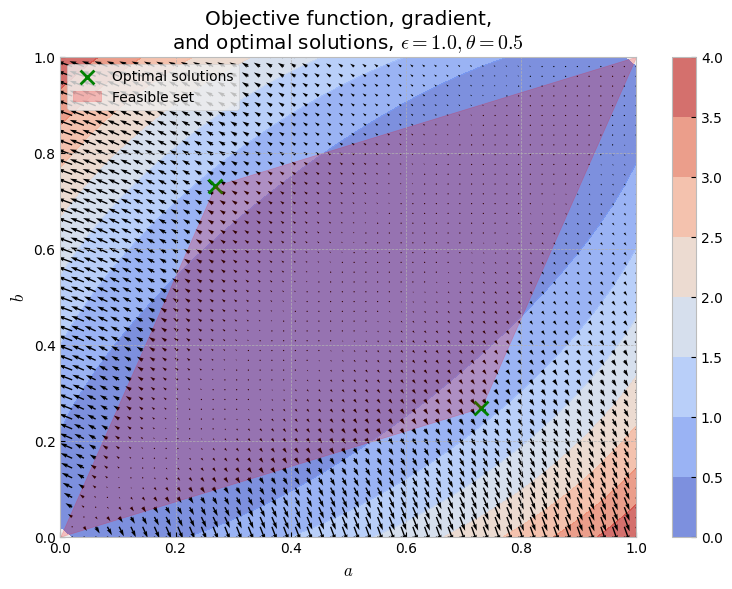

In [3]:
N = 1
THETA = 0.5
EPSILON = 1.0
NVALS = 50

p_theta = binom.pmf(np.arange(N + 1), N, THETA)
p_theta_dot = np.array([binom_derivative(i, N, THETA) for i in range(N + 1)])

a_vals = np.linspace(0, 1, NVALS)
b_vals = np.linspace(0, 1, NVALS)

grads_a = list()
grads_b = list()
fishers = list()

for a in a_vals:
    for b in b_vals:
        q_mat = np.array([[a, b], [1-a, 1-b]])
        grad = fisher_gradient(p_theta, p_theta_dot, q_mat)

        fishers.append(fisher_information_privatized(q_mat, N, THETA))

        grads_a.append(grad[0, 0])
        grads_b.append(grad[0, 1])

grads_a = np.array(grads_a).reshape((NVALS, NVALS), order="F")
grads_b = np.array(grads_b).reshape((NVALS, NVALS), order="F")
fishers = np.array(fishers).reshape((NVALS, NVALS), order="F")

opt_solutions, _, _ = binom_optimal_privacy(LinearSolver(), N, EPSILON, THETA)
xs = opt_solutions[:, 0]
ys = opt_solutions[:, 1]

# Feasible area plot
fig, ax = plt.subplots(figsize=(8, 6))

plt.contourf(a_vals, b_vals, fishers, cmap="coolwarm", alpha=0.7)
plt.colorbar()

plt.quiver(a_vals, b_vals, grads_a, grads_b, cmap="coolwarm")
plt.xlabel("$a$")
plt.ylabel("$b$")
plt.scatter(xs, ys, color="green", label="Optimal solutions", marker="x", s=100)

ax.fill_between(
    x=[0, (1 - np.exp(-EPSILON)) / (np.exp(EPSILON) - np.exp(-EPSILON)), (1 - np.exp(EPSILON)) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1], 
    y1=[0, (np.exp(EPSILON) - 1) / (np.exp(EPSILON) - np.exp(-EPSILON)), 1 - np.exp(-EPSILON) + (np.exp(-EPSILON) - 1) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1],
    y2=[0, (1 - np.exp(-EPSILON)) / (np.exp(2*EPSILON) - 1), (np.exp(-EPSILON) - 1) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1],
    label="Feasible set",
    color="red",
    alpha=0.2
)

plt.legend()
plt.title("Objective function, gradient,\n" + fr"and optimal solutions, $\epsilon = {EPSILON}, \theta = {THETA}$")
plt.tight_layout()
plt.savefig("figures/objective_function_gradient.png")
plt.show()

## Everything PLUS gradient ascent path

/Users/matej.vedak/Desktop/University of Vienna/Lukas master thesis/locally_efficient_differential_privacy/DP/utils.py:104: RuntimeWarning: invalid value encountered in divide
  2 * np.outer(p_theta_dot, Q_ptheta_dot) / Q_ptheta
/Users/matej.vedak/Desktop/University of Vienna/Lukas master thesis/locally_efficient_differential_privacy/DP/utils.py:105: RuntimeWarning: invalid value encountered in divide
  - np.outer(p_theta, Q_ptheta_dot_squared) / Q_ptheta_squared
/Users/matej.vedak/Desktop/University of Vienna/Lukas master thesis/locally_efficient_differential_privacy/DP/utils.py:177: RuntimeWarning: invalid value encountered in divide
  return np.sum(numerator / denominator)


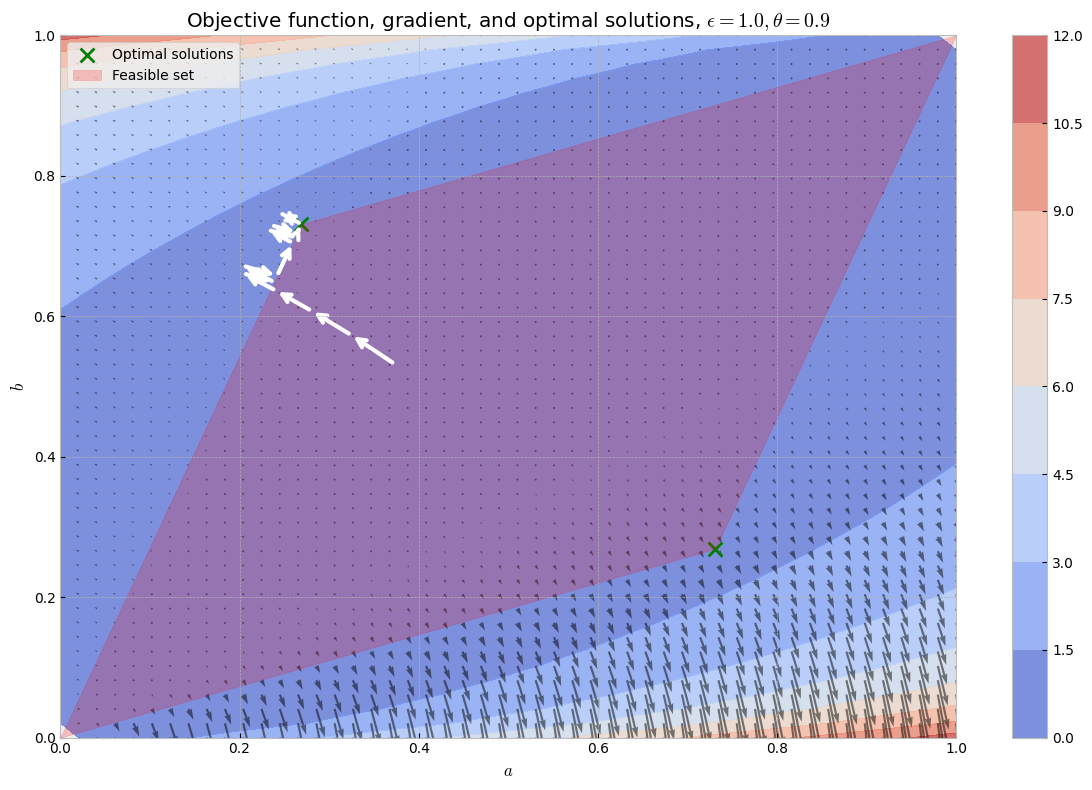

In [66]:
N = 1
THETA = 0.9
EPSILON = 1.0

p_theta = binom.pmf(np.arange(N + 1), N, THETA)
p_theta_dot = np.array([binom_derivative(i, N, THETA) for i in range(N + 1)])

a_vals = np.linspace(0, 1, NVALS)
b_vals = np.linspace(0, 1, NVALS)

grads_a = list()
grads_b = list()
fishers = list()

for a in a_vals:
    for b in b_vals:
        q_mat = np.array([[a, b], [1-a, 1-b]])
        grad = fisher_gradient(p_theta, p_theta_dot, q_mat)

        fishers.append(fisher_information_privatized(q_mat, N, THETA))

        grads_a.append(grad[0, 0])
        grads_b.append(grad[0, 1])

grads_a = np.array(grads_a).reshape((NVALS, NVALS), order="F")
grads_b = np.array(grads_b).reshape((NVALS, NVALS), order="F")
fishers = np.array(fishers).reshape((NVALS, NVALS), order="F")

opt_solutions, _, _,_ = binom_optimal_privacy(LinearSolver(), N, EPSILON, THETA)
xs = opt_solutions[:, 0]
ys = opt_solutions[:, 1]

_, _, history, _ = binom_optimal_privacy(PGAWithEdgeTraversal(), N, EPSILON, THETA)
all_history = np.array(history)

#colors = plt.cm.binary(np.linspace(0, 1, len(all_history)))
fig, ax = plt.subplots(figsize=(12, 8))

plt.contourf(a_vals, b_vals, fishers, cmap="coolwarm", alpha=0.7)
plt.colorbar()

plt.quiver(a_vals, b_vals, grads_a, grads_b, cmap="coolwarm", alpha=0.5)
plt.xlabel("$a$")
plt.ylabel("$b$")
plt.scatter(xs, ys, color="green", label="Optimal solutions", marker="x", s=100)
ax.fill_between(
    x=[0, (1 - np.exp(-EPSILON)) / (np.exp(EPSILON) - np.exp(-EPSILON)), (1 - np.exp(EPSILON)) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1], 
    y1=[0, (np.exp(EPSILON) - 1) / (np.exp(EPSILON) - np.exp(-EPSILON)), 1 - np.exp(-EPSILON) + (np.exp(-EPSILON) - 1) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1],
    y2=[0, (1 - np.exp(-EPSILON)) / (np.exp(2*EPSILON) - 1), (np.exp(-EPSILON) - 1) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1],
    label="Feasible set",
    color="red",
    alpha=0.2
)
for i in range(len(all_history) - 1):
    arrow = FancyArrowPatch((all_history[i,0,0], all_history[i,0,1]), (all_history[i+1,0,0], all_history[i+1,0,1]), 
                             color="white", arrowstyle='->', mutation_scale=15, linewidth=3)
    ax.add_patch(arrow)
plt.legend()
plt.title(fr"Objective function, gradient, and optimal solutions, $\epsilon = {EPSILON}, \theta = {THETA}$")
plt.tight_layout()
plt.savefig("figures/sample_ascent_path")
plt.show()

### Runtimes

Calculating for Linear solver
Calculating for n=1
Calculating for n=2
Calculating for n=3
Calculating for n=4
Calculating for n=5
Calculating for n=6
Calculating for n=7
Calculating for n=8
Calculating for n=9
Calculating for n=10
Calculating for n=11
Calculating for n=12
Calculating for n=13
Calculating for n=14
Calculating for n=15
Calculating for scipy_solver
Calculating for n=1
Calculating for n=2
Calculating for n=3
Calculating for n=4
Calculating for n=5
Calculating for n=6
Calculating for n=7
Calculating for n=8
Calculating for n=9
Calculating for n=10
Calculating for n=11
Calculating for n=12
Calculating for n=13
Calculating for n=14
Calculating for n=15
Calculating for n=16
Calculating for n=17
Calculating for PGAET
Calculating for n=1
Calculating for n=2
Calculating for n=3
Calculating for n=4
Calculating for n=5
Calculating for n=6
Calculating for n=7
Calculating for n=8
Calculating for n=9
Calculating for n=10
Calculating for n=11
Calculating for n=12
Calculating for n=13
C

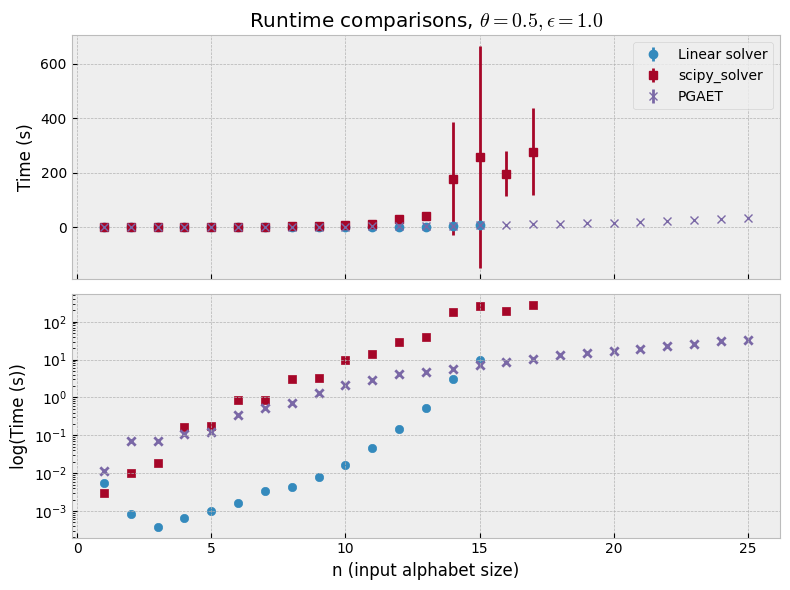

In [3]:
from time import time

def compare_runtimes(solvers, ns, theta, epsilon, log=False, n_restarts: int = 10):
    avg_times = list()
    stds = list()

    for i in range(len(solvers)):
        solver = solvers[i]
        print(f"Calculating for {solver.name}")
        solver_times = list()
        solver_stds = list()
        n_max = ns[i]
        for n in range(1, n_max + 1):
            print(f"Calculating for n={n}")
            times_for_n = list()
            for _ in range(n_restarts):
                t_start = time()
                _, _, _, _ = binom_optimal_privacy(solver, n, epsilon, theta)
                t_end = time()

                time_taken = t_end - t_start

                times_for_n.append(time_taken)
            avg_time = np.mean(times_for_n)
            std_time = np.std(times_for_n)
            solver_times.append(avg_time)
            solver_stds.append(std_time)

        avg_times.append(solver_times)
        stds.append(solver_stds)

    fig, ax = plt.subplots(figsize=(8, 6), nrows=2, sharex=True)

    formats = ["o", "s", "x", "d", "v", "^", "<", ">"]
    for i in range(len(solvers)):
        ns_to_plot = np.arange(1, ns[i] + 1)
        ax[0].errorbar(ns_to_plot, avg_times[i], yerr=stds[i], label=solvers[i].name, fmt=formats[i])
    ax[0].set_ylabel("Time (s)")
    ax[0].set_title(rf"Runtime comparisons, $\theta={theta}, \epsilon={epsilon}$")
    ax[0].legend()

    for i in range(len(solvers)):
        ns_to_plot = np.arange(1, ns[i] + 1)
        ax[1].scatter(ns_to_plot, avg_times[i], label=solvers[i].name, marker=formats[i])
    ax[1].set_xlabel("n (input alphabet size)")
    ax[1].set_ylabel("log(Time (s))")
    ax[1].set_yscale("log")

    plt.tight_layout()
    plt.show()

compare_runtimes([LinearSolver(), ScipySolver(), PGAWithEdgeTraversal()], [15, 17, 25], 0.5, 1.0, n_restarts=5)

### Cauchy bins

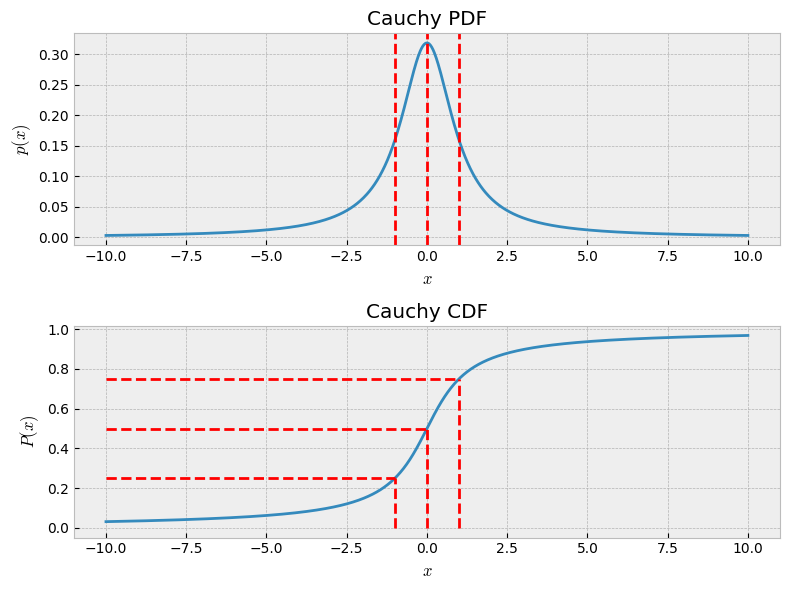

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use("bmh")

# Utility functions for the Cauchy distribution
def cauchy_cumulative(x, theta):
    return np.arctan(x - theta) / np.pi + 0.5

def cauchy_quantile(p, theta):
    return np.tan(np.pi * (p - 0.5)) + theta

def cauchy_pdf(x, theta):
    return 1 / (np.pi * (1 + (x - theta)**2))

k = 4
theta = 0

bin_endpoints = [cauchy_quantile(i / k, theta) for i in range(k + 1)]
p_theta = np.array([
    cauchy_cumulative(bin_endpoints[i + 1], theta) - cauchy_cumulative(bin_endpoints[i], theta)
    for i in range(k)
])
p_theta_dot = np.array([
    cauchy_pdf(cauchy_quantile((i - 1) / k, theta), theta)
    - cauchy_pdf(cauchy_quantile(i / k, theta), theta)
    for i in range(1, k+1)
])

fig, ax = plt.subplots(figsize=(8, 6), nrows=2)

ax[0].plot(np.linspace(-10, 10, 1000), cauchy_pdf(np.linspace(-10, 10, 1000), theta))
ax[0].set_title("Cauchy PDF")
ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$p(x)$")
for endpoint in bin_endpoints[1:-1]:
    ax[0].axvline(endpoint, color="red", linestyle="dashed")

ax[1].plot(np.linspace(-10, 10, 1000), cauchy_cumulative(np.linspace(-10, 10, 1000), theta))
ax[1].set_title("Cauchy CDF")
ax[1].set_xlabel("$x$")
ax[1].set_ylabel("$P(x)$")
for endpoint in bin_endpoints[1:-1]:
    ax[1].plot([endpoint, endpoint], [0, cauchy_cumulative(endpoint, theta)], color="red", linestyle="dashed")
    ax[1].plot([-10, endpoint], [cauchy_cumulative(endpoint, theta), cauchy_cumulative(endpoint, theta)], color="red", linestyle="dashed")

plt.tight_layout()
plt.show()

### Poisson approximation to the binomial

In [10]:
from DP.utils import binom_optimal_privacy

ns = [i + 2 for i in range(40)]
print(ns)
pga_best_fishes = list()
linear_fisher = list()
EPSILON = 0.5

for n in ns:
    print(n)
    result = binom_optimal_privacy(PGAWithEdgeTraversal(), n, EPSILON, 0.05)
    pga_best_fishes.append(result[-1])
    if n <= 15:
        result = binom_optimal_privacy(LinearSolver(), n, EPSILON, 0.05)
        linear_fisher.append(result[-1])

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41


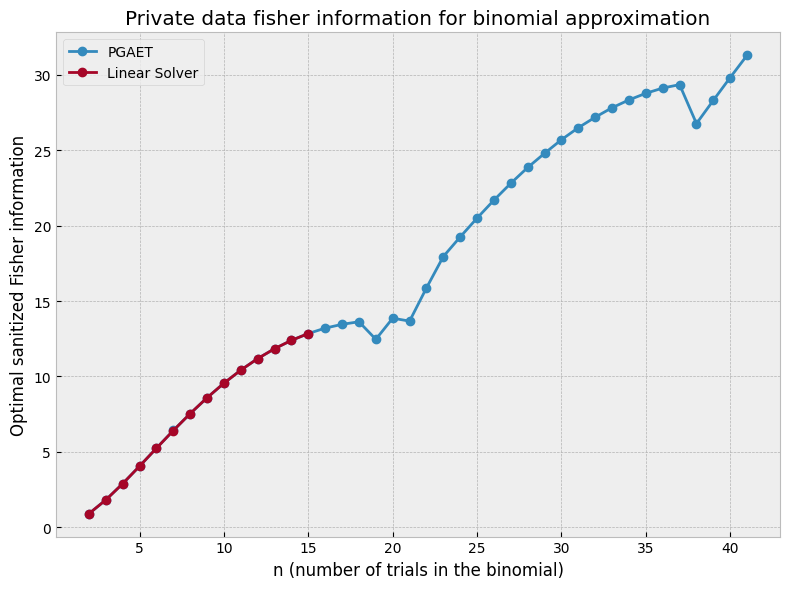

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(ns, pga_best_fishes, 'o-', label="PGAET")
ax.plot(ns[:14], linear_fisher, 'o-', label="Linear Solver")
ax.legend()
ax.set_xlabel("n (number of trials in the binomial)")
ax.set_ylabel("Optimal sanitized Fisher information")
ax.set_title("Private data fisher information for binomial approximation")

plt.tight_layout()
plt.show()